In [37]:
import pandas as pd
import re
import numpy as np
import snowballstemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import preprocessor as p
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [38]:
data = pd.read_csv("InformationSeeking.csv", encoding='utf-8', index_col=False) #Loading the data
len(data)

499

In [39]:
data.columns

Index(['Text', 'IS/NO?'], dtype='object')

# Cleaning The Tweets

In [40]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
def clean_tweet(row):
    text = p.clean(row['Text'])
    row['filtered_tweet'] = re.sub('\d', 'NUM', text)
    return row
data = data.apply(lambda row: clean_tweet(row), axis =1)

In [41]:
data = data[pd.notnull(data['filtered_tweet'])]
data = data[pd.notnull(data['IS/NO?'])]
len(data)

498

In [42]:
data['IS/NO?'].value_counts()

0.0    455
1.0     43
Name: IS/NO?, dtype: int64

# Over Sampling

In [43]:
values = []
for idx, val in data.iterrows():
    if val['IS/NO?'] == 1:
        for i in range(5):
            values.append(val)
    else:
        values.append(val)
data = pd.DataFrame(values)

In [44]:
data['IS/NO?'].value_counts()

0.0    455
1.0    215
Name: IS/NO?, dtype: int64

In [45]:
data = data.sample(frac=1, random_state=7).reset_index(drop=True)

In [46]:
data.head(5)

,Text,IS/NO?,filtered_tweet
0,Tell us there's cure instead....\n\nI said on ...,0.0,Tell us there's cure instead.... I said on beh...
1,Tencent may have accidentally leaked real dat....,0.0,Tencent may have accidentally leaked real dat....
2,Some #businesscontinuity examples of the impac...,0.0,Some #businesscontinuity examples of the impac...
3,Canadian scientists pioneer mask that kills vi...,0.0,Canadian scientists pioneer mask that kills vi...
4,So why did the DoD pick here in #Nebraska? L...,1.0,So why did the DoD pick here in #Nebraska? Log...


# TF-IDF Vectorizzation

In [47]:
english_stemmer = snowballstemmer.stemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [48]:
tfidf_vect = StemmedTfidfVectorizer(min_df=5, stop_words='english', analyzer='word', ngram_range=(1,2), max_features=2500, norm='l2', encoding='utf-8')

In [49]:
sentence_term_tfidf = tfidf_vect.fit_transform(data['filtered_tweet'])
sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+'_'+x)

In [50]:
sentence_term_df.head(5)

,W__account,W__account follow,W__acrual,W__actual,W__affect,W__affecting asian,W__africa,W__africa south,W__agenc,W__agencies believ,...,W__world,W__world countri,W__worri,W__wtf,W__wtf happen,W__wuhan,W__wuhan china,W__wuhan coronavirus,W__youtub,W__youtube coronavirus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.203333,0.254683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
sentence_term_df.shape

(670, 563)

In [52]:
labels = data['IS/NO?']
labels.shape

(670,)

In [53]:
features = sentence_term_df.values

In [54]:
features.shape

(670, 563)

# Train Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [56]:
len(X_train), len(X_test)

(469, 201)

# Print Classification Report

In [57]:
## For printing CLassification report with Accuracy
def print_classification_result(y_test, y_pred):
    target_names = ['Non-Information Seeking', 'Information Seeking']
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Avg. Accuracy: ', accuracy_score(y_test, y_pred))
    print('Specifity: ', specificity)

# Milestone 3 Code

# SVM

In [58]:
from sklearn import svm

In [59]:
svm_clf = svm.SVC()

In [60]:
sv_trained = svm_clf.fit(X_train,y_train)
y_pred = sv_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       1.00      1.00      1.00       141
    Information Seeking       1.00      1.00      1.00        60

               accuracy                           1.00       201
              macro avg       1.00      1.00      1.00       201
           weighted avg       1.00      1.00      1.00       201

Avg. Accuracy:  1.0
Specifity:  1.0


# Replacing Kernels

In [61]:
for kernel in ('linear', 'poly'):
    svm_clf = svm.SVC(kernel=kernel)
    sv_trained = svm_clf.fit(X_train,y_train)
    y_pred = sv_trained.predict(X_test)
    print("=================== For " + kernel+  " Kernel ================")
    print_classification_result(y_test, y_pred)

=================== For linear Kernel ================
                         precision    recall  f1-score   support

Non-Information Seeking       1.00      0.99      0.99       141
    Information Seeking       0.97      1.00      0.98        60

               accuracy                           0.99       201
              macro avg       0.98      0.99      0.99       201
           weighted avg       0.99      0.99      0.99       201

Avg. Accuracy:  0.9900497512437811
Specifity:  0.9858156028368794
=================== For poly Kernel ================
                         precision    recall  f1-score   support

Non-Information Seeking       1.00      1.00      1.00       141
    Information Seeking       1.00      1.00      1.00        60

               accuracy                           1.00       201
              macro avg       1.00      1.00      1.00       201
           weighted avg       1.00      1.00      1.00       201

Avg. Accuracy:  1.0
Specifity:  1.0


# Clustering

## K-Means

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [63]:
documents = data['filtered_tweet'].values.tolist()

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

In [64]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
predicted_lables = model.labels_.tolist()
original_lables = data['IS/NO?'].values.tolist()

In [66]:
class_0 = 0
class_1 = 0
for pred in predicted_lables:
    if pred == 0:
        class_0 += 1
    else:
        class_1 += 1

In [67]:
class_0, class_1

(505, 165)

In [68]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 coronavirus
 numnum
 truth
 num
 people
 new
 just
 hospital
 australia
 numnumnum
Cluster 1:
 china
 virus
 coronavirus
 wuhan
 outbreak
 corona
 details
 gt
 health
 novel


## Hierarchical Clustering

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
import scipy.cluster.hierarchy as shc

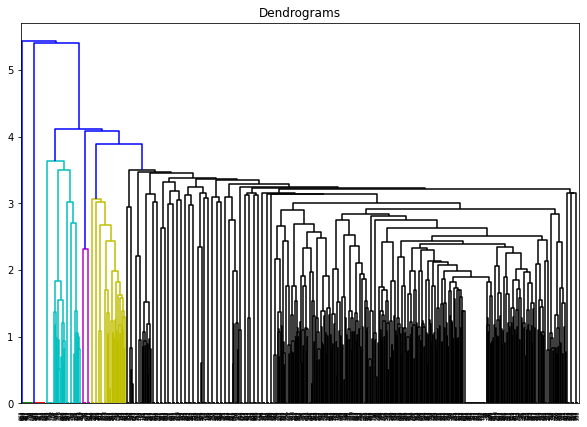

In [71]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(sentence_term_df, method='ward'))
plt.axhline(y=5.8, color='r', linestyle='--')

In [72]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
predictions = cluster.fit_predict(sentence_term_df)

In [73]:
class_0 = 0
class_1 = 0
for pred in predictions:
    if pred == 0:
        class_0 += 1
    else:
        class_1 += 1

In [74]:
class_0, class_1

(655, 15)

## DBScan

In [75]:
from sklearn.cluster import DBSCAN

In [76]:
clustering = DBSCAN(min_samples=6).fit(sentence_term_df)

In [77]:
clustering.labels_

array([-1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1,  2, -1, -1, -1,  1, -1, -1, -1,
        3, -1, -1, -1, -1,  3, -1, -1,  0, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1,
        3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1,  0,  2, -1, -1, -1,
       -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1

In [78]:
cluster_map = {}
for cluster in clustering.labels_:
    if cluster not in cluster_map:
        cluster_map[cluster] = 0
        cluster_map[cluster] += 1
    else:
        cluster_map[cluster] += 1

In [79]:
cluster_map

{-1: 598, 0: 9, 1: 27, 2: 15, 3: 6, 4: 15}

# Neural Networks

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [81]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
X1 = pad_sequences(X1)

C:\Users\Shreeya\Anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [82]:
Y1 = pd.get_dummies(data['IS/NO?']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(502, 25) (502, 2)
(168, 25) (168, 2)


In [83]:
y_test = []
for ent in Y1_test:
    if ent[0] == 1:
        y_test.append(0)
    else:
        y_test.append(1)
y_test= np.asarray(y_test)

embed_dim = 200
lstm_out = 200
max_features = 3000

In [84]:
def NN_model(hidden_layer):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
    model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
    for i in range(hidden_layer):
        model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
    yhat_classes = model.predict_classes(X1_test, verbose=0)
    accuracy = accuracy_score(y_test, yhat_classes)
    return {'layer': hidden_layer, 'accuracy': accuracy}

In [85]:
nn_results = []
for i in [1,2,3,4,5]:
    nn_results.append(NN_model(i))

C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\Shreeya\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:

In [86]:
nn_per = pd.DataFrame(nn_results)

In [87]:
nn_per

,layer,accuracy
0,1,0.982143
1,2,0.970238
2,3,0.690476
3,4,0.690476
4,5,0.690476


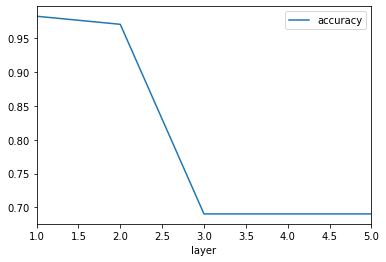

In [88]:
lines = nn_per.plot.line(x='layer', y='accuracy')

# Comparitive Analysis

In [89]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [90]:
def model_classification(model, train, test):
    X_train = sentence_term_df.iloc[train].values
    X_test = sentence_term_df.iloc[test].values
    y_train = data.iloc[train]['IS/NO?']
    y_test = data.iloc[test]['IS/NO?']
#     svm_clf = svm.SVC()
    trained = model.fit(X_train,y_train)
    y_pred = trained.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [91]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
X1 = pad_sequences(X1)

C:\Users\Shreeya\Anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [92]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
Y1 = pd.get_dummies(data['IS/NO?']).values
X1 = pad_sequences(X1)

In [93]:
def classification_report_for_NN(train,test):
#     print(len(train), len(test))
    X1_train = X1[train]
    X1_test = X1[test]
    Y1_train = Y1[train]
    Y1_test = Y1[test]
    
    embed_dim = 150
    lstm_out = 200
    max_features = 3000

    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
    model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    batch_size = 32
    model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
    yhat_classes = model.predict_classes(X1_test, verbose=0)
    y_test = []
    for ent in Y1_test:
        if ent[0] == 1:
            y_test.append(0)
        else:
            y_test.append(1)
    y_test= np.asarray(y_test)
    accuracy = accuracy_score(y_test, yhat_classes)
    precision = precision_score(y_test, yhat_classes, average='macro')
    recall = recall_score(y_test, yhat_classes, average='macro')
    f1 = f1_score(y_test, yhat_classes, average='macro')
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

## K-fold CV

In [94]:
kf = KFold(n_splits=5)
kf.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in kf.split(data):
    svm_scores.append(model_classification(svc, train, test))
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))

C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  del sys.path[0]
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
C:\Users\Shreeya\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argum

In [95]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

In [96]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]

In [97]:
model_map = {0: 'SVM', 1: 'Decision Tree', 2: 'Random Forest', 3: 'Neural Net'}

In [98]:
results = []
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'kFold'
    results.append(score_mean)

## LeavePOut

In [99]:
from sklearn.model_selection import LeavePOut
lpo = LeavePOut(300)
lpo.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
count = 0
for train, test in lpo.split(data):
    count += 1
    svm_scores.append(model_classification(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))
    if count == 5:
        break

C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  del sys.path[0]
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
C:\Users\Shreeya\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argum

In [100]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'LeavePOut'
    results.append(score_mean)

## Random Split

In [101]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)
TRAIN: [5 2 3] TEST: [4 1 0]
TRAIN: [5 1 4] TEST: [0 2 3]
TRAIN: [5 0 2] TEST: [4 3 1]
TRAIN: [4 1 0] TEST: [2 3 5]
TRAIN: [0 5 1] TEST: [3 4 2]


In [102]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
sss.get_n_splits(features, labels)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in sss.split(features, labels):
    count += 1
    svm_scores.append(model_classification(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))

C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  del sys.path[0]
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
C:\Users\Shreeya\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Shreeya\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `dropout` argum

In [103]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'Random SubSampling'
    results.append(score_mean)

In [104]:
pd.DataFrame(results)

,precision,recall,f1,accuracy,model,CV
0,0.997826,0.998876,0.998336,0.998507,SVM,kFold
1,0.961109,0.980088,0.969525,0.973134,Decision Tree,kFold
2,0.995387,0.997813,0.996567,0.997015,Random Forest,kFold
3,0.982749,0.991062,0.986529,0.988060,Neural Net,kFold
4,0.977334,0.944070,0.958783,0.966667,SVM,LeavePOut
5,0.903775,0.912262,0.907797,0.922000,Decision Tree,LeavePOut
6,0.972267,0.942172,0.955612,0.964000,Random Forest,LeavePOut
7,0.968016,0.967606,0.967406,0.972667,Neural Net,LeavePOut
8,0.980457,0.956153,0.966614,0.971940,SVM,Random SubSampling
9,0.944953,0.952779,0.948263,0.954627,Decision Tree,Random SubSampling


# Feature Selection

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [106]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
                    ('classification', DecisionTreeClassifier())
                   ])
trained = clf.fit(X_train, y_train)
y_pred = trained.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print(precision, recall, accuracy, f1)

0.96875 0.9858156028368794 0.9800995024875622 0.976676723137619


C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)


In [107]:
def model_classification_pipeline(model, train, test):
    X_train = sentence_term_df.iloc[train].values
    X_test = sentence_term_df.iloc[test].values
    y_train = data.iloc[train]['IS/NO?']
    y_test = data.iloc[test]['IS/NO?']
    clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
                    ('classification', model)
                   ])
    trained = clf.fit(X_train,y_train)
    y_pred = trained.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [108]:
kf = KFold(n_splits=5)
kf.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in kf.split(data):
    svm_scores.append(model_classification_pipeline(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification_pipeline(dt, train, test))
    rf_scores.append(model_classification_pipeline(rf, train, test))
#     nn_scores.append(classification_report_for_NN(train,test))

C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)
C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)
C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)
C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\svm\_classes.py:226: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  FutureWarning)
C:\Users\Shreeya

In [109]:
fs_results = []
model_scores = [svm_scores, dt_scores, rf_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'kFold'
    fs_results.append(score_mean)

In [110]:
pd.DataFrame(fs_results)

,precision,recall,f1,accuracy,model,CV
0,0.970935,0.982713,0.976123,0.979104,SVM,kFold
1,0.972103,0.985755,0.978080,0.980597,Decision Tree,kFold
2,0.982913,0.992610,0.987487,0.989552,Random Forest,kFold
